In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import os

from random import shuffle, randint, choice
from keras.datasets import mnist
from keras.layers import Input
from keras.layers.core import Dense
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.convolutional import UpSampling2D
from keras.models import Model, model_from_json
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [0]:
## Generates random image with squares and circles

def getRandomImage():
  imageSize = 100
  size = 25
  nbShapes = 5
  
  xy = lambda: randint(0, 100)
  
  # Create a white image
  img = np.zeros((imageSize, imageSize, 3), np.uint8)
  cv2.rectangle(img, (0, 0), (imageSize, imageSize), (122, 122, 122), -1)
  
  greyImg = np.copy(img)
  
  # Adds some shapes
  for i in range(nbShapes):
    x0, y0 = xy(), xy()
    isRect = choice((True, False))
    if isRect:
      cv2.rectangle(img, (x0, y0), (x0 + size, y0 + size), (255, 0, 0), -1)
      cv2.rectangle(greyImg, (x0, y0), (x0 + size, y0 + size), (255, 255, 255), -1)
      
    else:
      cv2.circle(img, (x0, y0), int(size / 2), (0, 0, 255), -1)
      cv2.circle(greyImg, (x0, y0), int(size / 2), (255, 255, 255), -1)
      
  return cv2.resize(img, (48, 48)), cv2.resize(greyImg, (48, 48))

In [0]:
## Creates the dataset

def getDataset(display = False):
  # Show what the dataset looks like
  if display:
    colorImg, greyImg = getRandomImage()
    img = np.hstack((colorImg, greyImg))
    cv2.imshow("Dataset", cv2.resize(img, (200, 100)))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
  # for i in range
  
  x_train, x_test, y_train, y_test = [], [], [], []
  
  
  # Add training examples
  for i in range(10000):
    colorImg, greyImg = getRandomImage()
    greyImg = cv2.cvtColor(greyImg, cv2.COLOR_RGB2GRAY)
    x_train.append(greyImg.astype('float32') / 255.)
    y_train.append(colorImg.astype('float32') / 255.)
    
  # Add test examples
  for i in range(1000):
    colorImg, greyImg = getRandomImage()
    greyImg = cv2.cvtColor(greyImg, cv2.COLOR_RGB2GRAY)
    x_test.append(greyImg.astype('float32') / 255.)
    y_test.append(colorImg.astype('float32') / 255.)
    
  
  # Reshape
  x_train = np.array(x_train).reshape((-1, 48, 48, 1))
  x_test = np.array(x_test).reshape((-1, 48, 48, 1))
  y_train = np.array(y_train).reshape((-1, 48, 48, 3))
  y_test = np.array(y_test).reshape((-1, 48, 48, 3))
  
  return x_train, y_train, x_test, y_test

In [0]:
## Creates the Convolutional Autoencoder

def getModel():
  input_img = Input(shape = (48, 48, 1))
  x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(input_img)
  x = MaxPooling2D((2, 2), padding = 'same')(x)
  x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
  x = MaxPooling2D((2, 2), padding = 'same')(x)
  x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x)
  encoded = MaxPooling2D((2, 2), padding = 'same')(x)
  
  # 6x6x32 -- bottleneck
  
  x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation = 'relu', padding = 'same')(x)
  
  
  # Create model
  autoencoder = Model(input_img, decoded)
  return autoencoder

In [0]:
## Trains the model for 15 epochs

def trainModel():
  
  # Load dataset
  print("Loading dataset...")
  x_train_gray, x_train, x_test_gray, x_test = getDataset()
  
  # Create model description
  print("Creating model...")
  model = getModel()
  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  # Train model
  print("Training model...")
  model.fit(x_train_gray, x_train,
            epochs = 15,
            batch_size = 128,
            shuffle = True,
            validation_data = (x_test_gray, x_test),
            callbacks = [TensorBoard(log_dir = '/tb', histogram_freq = 0, write_graph = False)])
  
  
  # Evaluate loaded model on test data
  print("Evaluating model...")
  score = model.evaluate(x_train_gray, x_train, verbose = 0)
  print("{}: {} %".format(model.metrics_names[1], score[1] * 100))
  
  
  # Serialize model to JSON
  print("Saving model...")
  model_json = model.to_json()
  with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
  
  # Serialize weights to HDF5
  print("Saving weights...")
  model.save_weights("model.h5")

In [0]:
## Tests the model and shows results

def testModel():
  # Load JSON model description
  with open('model.json', 'r') as json_file:
    modelJSON = json_file.read()
    
  
  # Build model from JSON description
  print("Loading model...")
  model = model_from_json(modelJSON)
  
  
  # Load weights
  print("Loading weights...")
  model.load_weights("model.h5")
  
  
  _, _, x_test_gray, x_test = getDataset()
  x_test_gray = x_test_gray[:10]
  x_test = x_test[:10]
  
  print("Making predictions...")
  predictions = model.predict(x_test_gray)
  x_test_gray = [cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in x_test_gray]
  
  
  img = np.vstack((np.hstack(x_test_gray),
                   np.hstack(predictions),
                   np.hstack(x_test)))
  
  
  print("Input image, reconstructed image, and ground truth displayed top to bottom")
  plt.imshow(img)  

Loading dataset...
Creating model...
Training model...
Train on 10000 samples, validate on 1000 samples
Epoch 1/15
10000/10000 [==============================] - 4s 365us/step - loss: 0.7921 - acc: 0.1178 - val_loss: 0.6886 - val_acc: 0.1280
Epoch 2/15
10000/10000 [==============================] - 3s 316us/step - loss: 0.6792 - acc: 0.1299 - val_loss: 0.6708 - val_acc: 0.1373
Epoch 3/15
10000/10000 [==============================] - 3s 313us/step - loss: 0.6623 - acc: 0.1457 - val_loss: 0.6483 - val_acc: 0.1637
Epoch 4/15
10000/10000 [==============================] - 3s 314us/step - loss: 0.6417 - acc: 0.1691 - val_loss: 0.6379 - val_acc: 0.1747
Epoch 5/15
10000/10000 [==============================] - 3s 314us/step - loss: 0.6293 - acc: 0.1738 - val_loss: 0.6422 - val_acc: 0.1723
Epoch 6/15
10000/10000 [==============================] - 3s 315us/step - loss: 0.6320 - acc: 0.1736 - val_loss: 0.6190 - val_acc: 0.1785
Epoch 7/15
10000/10000 [==============================] - 3s 315us/s

W0808 16:16:38.542657 139742888171392 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Making predictions...
Input image, reconstructed image, and ground truth displayed top to bottom


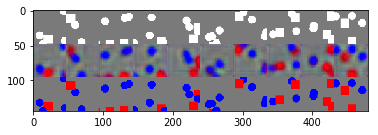

In [8]:
getRandomImage()
getDataset()
getModel()
trainModel()
testModel()